# Hyperparameter Tuning the ANN using Optuna

Hyperparameter tuning is a crucial step in building efficient and high-performing Artificial Neural Networks (ANNs).

It involves selecting the best set of hyperparameters to maximize the model's performance.


> Hyperparameter Tuning ML model using GridSearchCV: [**here**](https://github.com/nikitaprasad21/ML-Cheat-Codes/blob/main/Feature-Engineering/ML-Pipeline/ml_pipeline.ipynb)


Let's utilize Optuna, an open-source hyperparameter optimization framework, that uses **Bayesian Optimization  Tree-structured Parzen Estimator (TPE), and other advanced techniques to efficiently navigate the hyperparameter space**, reducing time and computational cost while achieving better results.

It is helpful in simplifying and automating the process, making it easier to find the optimal configuration your ANN.

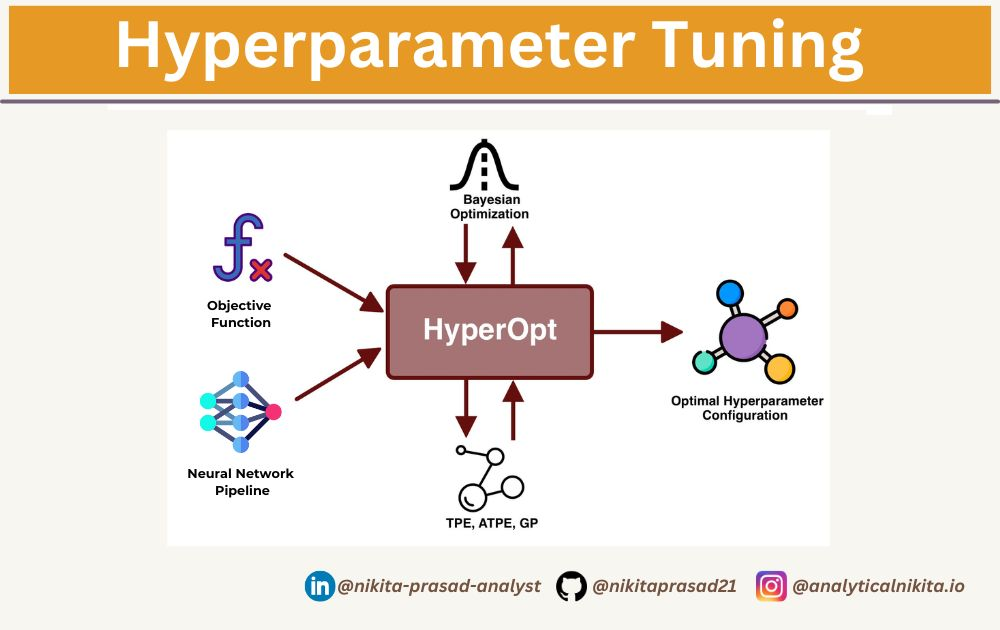

### Importing Libraries

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

In [ ]:
# Check for GPU Availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Transforming Dataset

In [ ]:
# Define transformations for normalization and tensor conversion
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts image to PyTorch tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

### Utilizing PyTorch's Dataset

In [ ]:
# Load the training dataset
train_dataset = datasets.FashionMNIST(
    root = "./data",  # Directory to save the data
    train = True, # Load training set
    transform = transform, # Apply the transformations
    download = True # Download the data if not present
)

# Load the test dataset
test_dataset = datasets.FashionMNIST(
    root='./data',
    train=False,  # Load test set
    transform=transform,
    download=True
)

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.3MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 201kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.72MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 20.1MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



### Implementing Simple ANN Class

In [ ]:
class NeuralNetwork(nn.Module):

  def __init__(self, input_dim, output_dim, num_hidden_layers, num_neurons_per_layer, dropout_rate):
    super().__init__()
    layers = []
    for i in range(num_hidden_layers):
        layers.append(nn.Linear(input_dim, num_neurons_per_layer)),
        layers.append(nn.BatchNorm1d(num_neurons_per_layer)),
        layers.append(nn.ReLU()),
        layers.append(nn.Dropout(dropout_rate)),

        input_dim = num_neurons_per_layer
    layers.append(nn.Linear(num_neurons_per_layer, output_dim))

    self.model = nn.Sequential(*layers)

  def forward(self, x):
    return self.model(x)

### Implementing the Objective Function

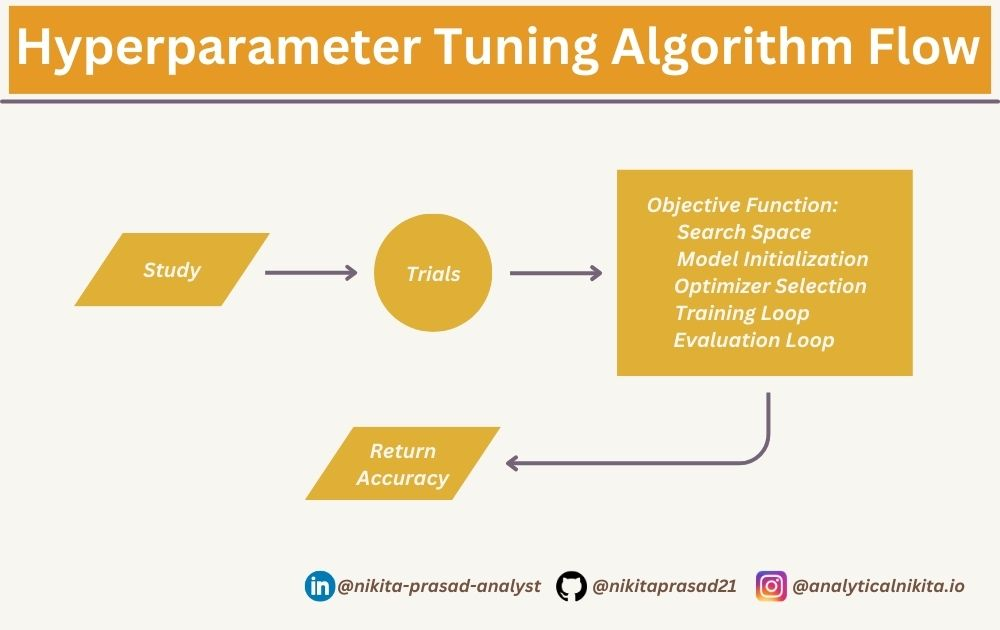

In [ ]:
# Objective Function
def objective_function(trial):

  # Hyperparameter
  num_hidden_layers = trial.suggest_int("num_hidden_layers", 1, 5)
  num_neurons_per_layer = trial.suggest_int("num_neurons_per", 8, 128, step = 8)
  epochs = trial.suggest_int("epochs", 10, 50, step = 10)
  learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log = True)
  dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5, step = 0.1)
  batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
  optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "AdamW", "RMSprop"])
  weigh_decay = trial.suggest_float("weigh_decay", 1e-5, 1e-3, log = True) #  usually best range for weight_decay


  # Wrap datasets in DataLoaders
  train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory = True)
  test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True, pin_memory = True)

  # Model Initialization
  input_dim = 784
  output_dim = 10
  model = NeuralNetwork(input_dim, output_dim, num_hidden_layers, num_neurons_per_layer, dropout_rate).to(device)

  # Optimizer Selection
  criterion = nn.CrossEntropyLoss()
  if optimizer_name == "Adam":
    optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay = weigh_decay)

  if optimizer_name == "SGD":
    optimizer = optim.SGD(model.parameters(), lr = learning_rate, weight_decay = weigh_decay)

  if optimizer_name == "AdamW":
    optimizer = optim.AdamW(model.parameters(), lr = learning_rate, weight_decay = weigh_decay)

  else:
    optimizer = optim.RMSprop(model.parameters(), lr = learning_rate, weight_decay = weigh_decay)


  # Training loop
  for epoch in range(epochs):
      model.train()
      for batch_features, batch_labels in train_loader:
            # Move Data to GPU
            batch_features, batch_labels = batch_features.view(-1, 28*28).to(device), batch_labels.to(device)
            # Forward Pass
            outputs = model(batch_features)
            # Calculate Loss
            loss = criterion(outputs, batch_labels)
            # Backward Pass
            optimizer.zero_grad()
            loss.backward()
            # Update gradients
            optimizer.step()

  # Evaluation Loop
  model.eval()

  # Evaluation on test_set
  total = 0
  correct = 0
  with torch.no_grad():
    for batch_features, batch_labels in test_loader:
      batch_features, batch_labels = batch_features.view(-1, 28*28).to(device), batch_labels.to(device)
      outputs = model(batch_features)
      _, predicted = torch.max(outputs, 1)
      total += batch_labels.size(0)
      correct += (predicted == batch_labels).sum().item()

    accuracy = correct / total
  return accuracy

### Installing Optuna

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.8 MB/s eta 0:00:00


### Importing Optuna and Creating Study

In [ ]:
import optuna

study = optuna.create_study(study_name = "FMNIST Study", direction='maximize', sampler = optuna.samplers.TPESampler())
study.optimize(objective_function, n_trials = 15)

[I 2025-01-16 08:50:42,208] A new study created in memory with name: FMNIST Study
[I 2025-01-16 08:55:01,626] Trial 0 finished with value: 0.8702 and parameters: {'num_hidden_layers': 3, 'num_neurons_per': 128, 'epochs': 20, 'learning_rate': 0.0007347067900144206, 'dropout_rate': 0.5, 'batch_size': 64, 'optimizer': 'RMSprop', 'weigh_decay': 0.00025447156994993673}. Best is trial 0 with value: 0.8702.
[I 2025-01-16 09:04:48,631] Trial 1 finished with value: 0.8591 and parameters: {'num_hidden_layers': 1, 'num_neurons_per': 88, 'epochs': 50, 'learning_rate': 0.04509407329462634, 'dropout_rate': 0.0, 'batch_size': 32, 'optimizer': 'AdamW', 'weigh_decay': 1.3850795705833588e-05}. Best is trial 0 with value: 0.8702.
[I 2025-01-16 09:13:39,989] Trial 2 finished with value: 0.8936 and parameters: {'num_hidden_layers': 5, 'num_neurons_per': 128, 'epochs': 40, 'learning_rate': 0.0025051690412244503, 'dropout_rate': 0.1, 'batch_size': 128, 'optimizer': 'AdamW', 'weigh_decay': 0.00056642008988285

In [ ]:
# Best Trial
print("Best Trial:")
print(f"  Value: {study.best_value}")
print(f"  Params: {study.best_params}")

Best Trial:
  Value: 0.8975
  Params: {'num_hidden_layers': 3, 'num_neurons_per': 128, 'epochs': 40, 'learning_rate': 0.010847368414005187, 'dropout_rate': 0.2, 'batch_size': 128, 'optimizer': 'AdamW', 'weigh_decay': 0.0009208220248685574}


In [ ]:
# Trials to dataframe
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_dropout_rate,params_epochs,params_learning_rate,params_num_hidden_layers,params_num_neurons_per,params_optimizer,params_weigh_decay,state
0,0,0.8702,2025-01-16 08:50:42.211001,2025-01-16 08:55:01.626488,0 days 00:04:19.415487,64,0.5,20,0.000735,3,128,RMSprop,0.000254,COMPLETE
1,1,0.8591,2025-01-16 08:55:01.628179,2025-01-16 09:04:48.631190,0 days 00:09:47.003011,32,0.0,50,0.045094,1,88,AdamW,0.000014,COMPLETE
2,2,0.8936,2025-01-16 09:04:48.632904,2025-01-16 09:13:39.989475,0 days 00:08:51.356571,128,0.1,40,0.002505,5,128,AdamW,0.000566,COMPLETE
3,3,0.8333,2025-01-16 09:13:39.991271,2025-01-16 09:15:38.008172,0 days 00:01:58.016901,64,0.4,10,0.002791,1,16,SGD,0.000045,COMPLETE
4,4,0.8765,2025-01-16 09:15:38.009865,2025-01-16 09:21:57.226232,0 days 00:06:19.216367,64,0.2,30,0.000035,4,80,RMSprop,0.000269,COMPLETE
5,5,0.7123,2025-01-16 09:21:57.227903,2025-01-16 09:30:37.025225,0 days 00:08:39.797322,32,0.1,40,0.088509,5,40,RMSprop,0.000012,COMPLETE
6,6,0.8886,2025-01-16 09:30:37.027191,2025-01-16 09:34:34.632438,0 days 00:03:57.605247,64,0.1,20,0.000364,2,96,Adam,0.000037,COMPLETE
7,7,0.8178,2025-01-16 09:34:34.634172,2025-01-16 09:45:08.342983,0 days 00:10:33.708811,128,0.0,50,0.008089,5,24,SGD,0.000527,COMPLETE
8,8,0.8879,2025-01-16 09:45:08.344616,2025-01-16 09:53:24.909085,0 days 00:08:16.564469,32,0.0,40,0.000847,4,72,RMSprop,0.000018,COMPLETE
9,9,0.8497,2025-01-16 09:53:24.910587,2025-01-16 09:59:52.350942,0 days 00:06:27.440355,64,0.4,30,0.000037,5,88,SGD,0.000320,COMPLETE


### Optuna Visualization

In [ ]:
from optuna.visualization import plot_optimization_history

# 1. Plot Optimization History
plot_optimization_history(study).show()

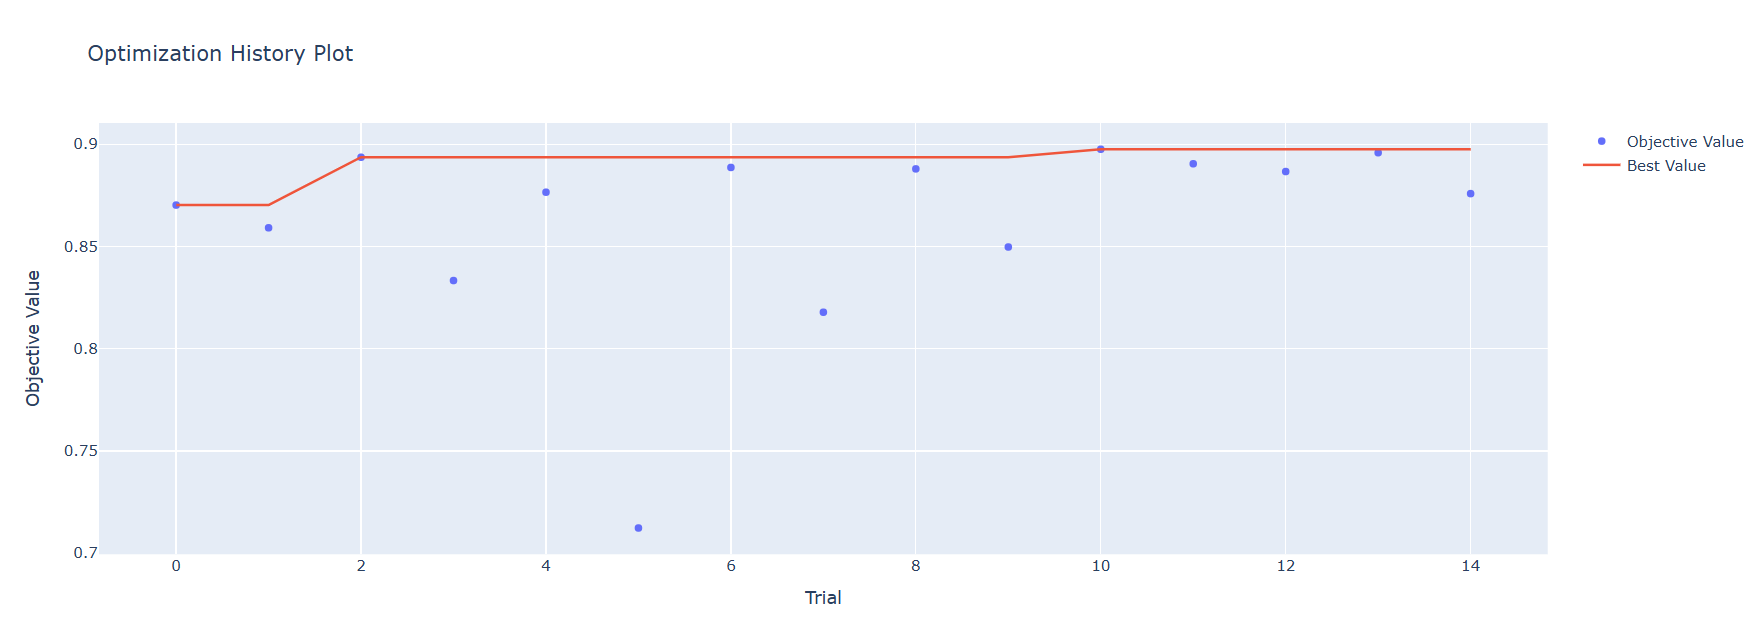

The Optimzation History Plot is plotted between `objective value` in this case accuracy and `trial number`.

As concluded from the plot that with increase in number of trial accuracy is improving and after 10th trial it's slightly descresing.

So, this is helpful in planning for number of trial in order to reduce compuational cost.

In [ ]:
from optuna.visualization import plot_parallel_coordinate

# 2. Parallel Coordinate Plot
plot_parallel_coordinate(study, params=["num_hidden_layers", "num_neurons_per", "epochs", "learning_rate", "dropout_rate", "batch_size", "optimizer", "weigh_decay"]).show()

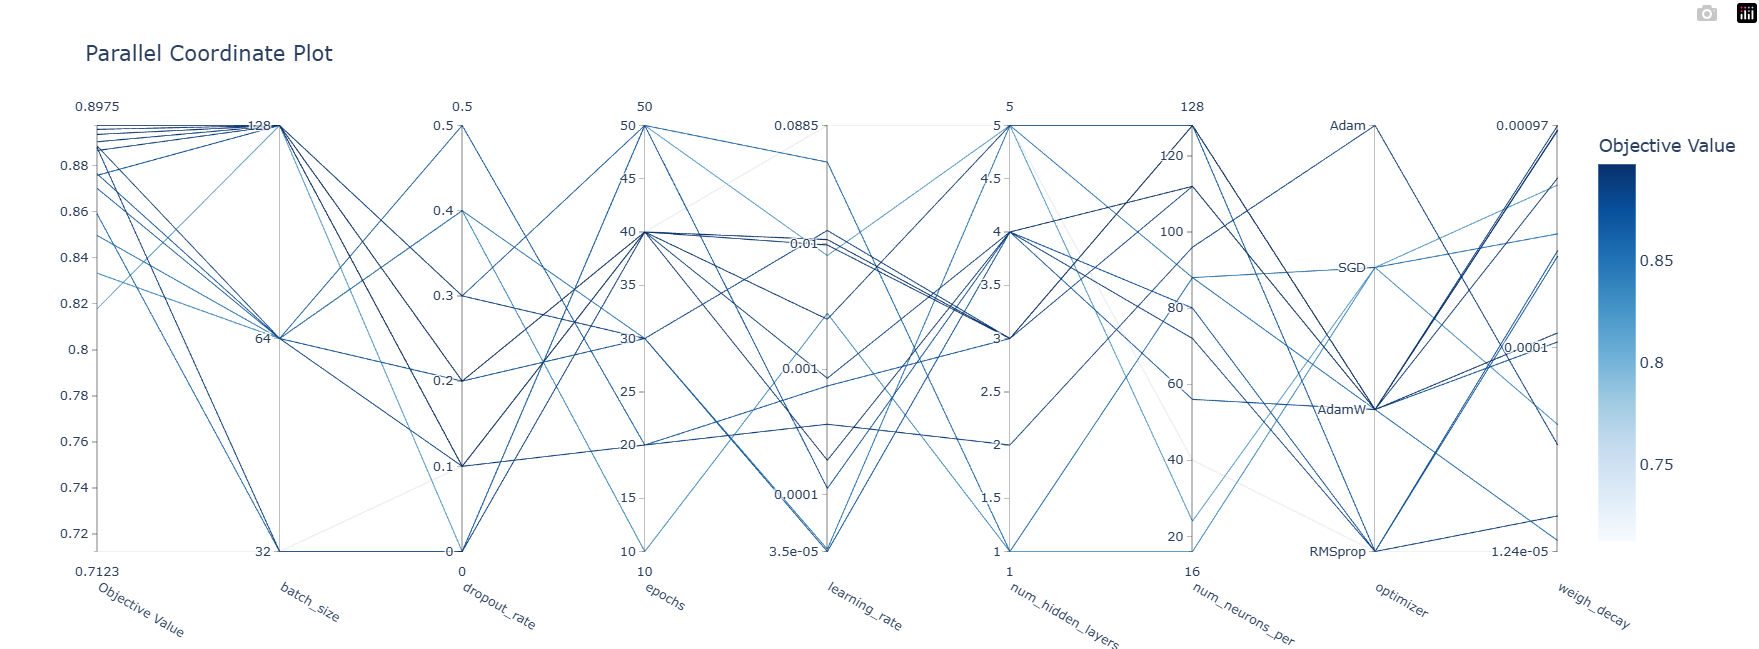

  Parallel coordiante plot can clealy show the relation between objective value and all the trial pameters.
  
  According to this plot, the best values of
  * 'num_hidden_layers' can be from 3 to 4
  * 'num_neurons_per_layer'is 128,
  * 'epochs' is 40,
  * 'learning_rate' is around 0.01 range,
  * 'dropout_rate' is 0.2,
  * 'batch_size' is 128,
  * 'optimizer' is 'AdamW',
  * 'weigh_decay' is around 0.00090 - 0.00097





> Stay tuned for Hyperparameter Tuning ML Models using Optuna and Don't forget to Star this Github Repository for more such contents.

